In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3
import json
from pandas.io.json import json_normalize
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Utility functions

In [ ]:
# This function allows us to flatten out the columns in the pandas dataframe which are in the json format

def load_df(csv_path='../input/train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']):

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

def column_type(dataFrame):
    
    type_keys = np.array(dataFrame.dtypes.unique())
    
    Dict = {object_type:[] for object_type in type_keys }
    
    for column in dataFrame.columns:
        Dict[dataFrame[column].dtype].append(column)
    
    return Dict


def column_counts(dataFrame, threshold):
    
    type_keys = np.array(dataFrame.dtypes.unique())
    
    Dict = {object_type:{} for object_type in type_keys}
    
    for column in dataFrame.columns:
        
        if len(dataFrame[column].unique()) <= threshold:
            
            Dict[dataFrame[column].dtype][column] = len(dataFrame[column].unique())
            
    return Dict



def date_time_conversion(dataFrame, column, year = 0, month = 0, day = 0, weekday = 0, unit = None ,errors = None , format = None):
    
    dataFrame[column] = pd.to_datetime(dataFrame[column], format = format, errors = errors, unit = unit)
    
    if year: 
        dataFrame[column+'_year'] = dataFrame[column].apply(lambda x: x.year)
    
    if month:
        dataFrame[column+'_month'] = dataFrame[column].apply(lambda x: x.month)
        
    if day:
        dataFrame[column+'_day'] = dataFrame[column].apply(lambda x: x.day)
        
    if weekday:
        dataFrame[column+'_weekday'] = dataFrame[column].apply(lambda x: x.weekday())
    
    return dataFrame
        
    
    
    
    

    


    
    
    
    

# Analysis Functions

In [ ]:
def NaN_value_count(dataFrame):
    for column in dataFrame.columns:
        print('column name:'+str(column))
        print('number of NaN values: '+str(dataFrame[column].isnull().sum() ))
        print('percentage of NaN values: '+str(dataFrame[column].isnull().sum()/dataFrame.shape[0] ))
        print('------------')

        
def count_distribution(dataFrame,column):
    column_count = pd.Series.to_frame(dataFrame.groupby(column).size(),'count')
    column_count.reset_index(inplace = True)
    total = column_count['count'].sum()
    column_count['proportion'] = column_count['count']/total
    return column_count

# Loading the data


### required

In [ ]:
train_unflatten = pd.read_csv("../input/train.csv")


In [ ]:
test_unflatten  = pd.read_csv("../input/test.csv")

In [ ]:
df_train = load_df()

In [ ]:
df_test = load_df(csv_path='../input/test.csv')

In [ ]:
# Adding the relevant transaction values to the training set

df_train["totals.transactionRevenue"].fillna(0, inplace=True)

### analysis

In [ ]:
# print unique id's in training set
# print total transactions in training set
print(len(train_unflatten['fullVisitorId'].unique()))
print(train_unflatten.shape[0])

In [ ]:
df_train.head()

In [ ]:
# print unique id's in test set
# print total transactions in test set

print(len(test_unflatten['fullVisitorId'].unique()))
print(test_unflatten.shape[0])

In [ ]:
df_test.head()

# Preprocessing the data


### required

In [ ]:
# Types of columns that have a total number of unique values less than a threshold
# note if we set threshold = 1 we are looking for constant columns. 

constant_column_dict = column_counts(df_train, threshold = 1)
column_counts(df_train,threshold = 3)

In [ ]:
# Lets start by removing any constant columns 

constant_dict_key_list = list(constant_column_dict.keys())
constant_columns = list(constant_column_dict[constant_dict_key_list[0]].keys())
constant_columns
df_train = df_train.drop(constant_columns+['trafficSource.campaignCode'], axis = 1)
#['trafficSource.campaignCode']
df_test = df_test.drop(constant_columns, axis = 1)

### Analysis

In [ ]:
# Visualise the types of columns we have in our dataFrame
column_type(df_train)

In [ ]:
# Types of columns that have a total number of unique values less than a threshold
# note if we set threshold = 1 we are looking for constant columns. 

constant_column_dict = column_counts(df_train, threshold = 1)
column_counts(df_train,threshold = 3)


The following columns have the following number of unique entries

{dtype('O'): {'socialEngagementType': 1,
  'device.browserSize': 1,
  'device.browserVersion': 1,
  'device.deviceCategory': 3,
  'device.flashVersion': 1,
  'device.language': 1,
  'device.mobileDeviceBranding': 1,
  'device.mobileDeviceInfo': 1,
  'device.mobileDeviceMarketingName': 1,
  'device.mobileDeviceModel': 1,
  'device.mobileInputSelector': 1,
  'device.operatingSystemVersion': 1,
  'device.screenColors': 1,
  'device.screenResolution': 1,
  'geoNetwork.cityId': 1,
  'geoNetwork.latitude': 1,
  'geoNetwork.longitude': 1,
  'geoNetwork.networkLocation': 1,
  'totals.bounces': 2,
  'totals.newVisits': 2,
  'totals.visits': 1,
  'trafficSource.adwordsClickInfo.adNetworkType': 3,
  'trafficSource.adwordsClickInfo.criteriaParameters': 1,
  'trafficSource.adwordsClickInfo.isVideoAd': 2,
  'trafficSource.adwordsClickInfo.slot': 3,
  'trafficSource.campaignCode': 2,
  'trafficSource.isTrueDirect': 2},
 dtype('int64'): {},
 dtype('bool'): {'device.isMobile': 2}}

In [ ]:
# We can check that a list of columns have been successfully removed
df_train.head()
df_train.shape

## Preprocessing Date/time features

### Required

In [ ]:
# lets change the relevant columns to datetime ones 
date_time_conversion(df_train, column = 'date', year = 1, month = 1, day = 1, weekday = 1, unit = None, errors = 'ignore', format = '%Y%m%d')


In [ ]:
date_time_conversion(df_train,column='visitStartTime', year = 1, month = 1, day = 1, weekday = 1,unit='s',errors='ignore')

### Analysis 

In [ ]:
df_train.columns



Info on some of the fields 

*fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
*channelGrouping - The channel via which the user came to the Store.
*date - The date on which the user visited the Store.
*device - The specifications for the device used to access the Store.
*geoNetwork - This section contains information about the geography of the user.
*sessionId - A unique identifier for this visit to the store.
*socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
*totals - This section contains aggregate values across the session.
*trafficSource - This section contains information about the Traffic Source from which the session originated.
*visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you *should use a combination of fullVisitorId and visitId.
*visitNumber - The session number for this user. If this is the first session, then this is set to 1.
*visitStartTime - The timestamp (expressed as POSIX time).

# Create training and validation set ordered by date

### required 

In [ ]:
# sort the rows via date first
df_train.sort_values(by='date', inplace= True)

In [ ]:
# obtain an index according to split size

split_size = 0.7
index = df_train.shape[0]*split_size
split_index = int(index)

In [ ]:
train = df_train.iloc[:split_index,:]
val = df_train.iloc[split_index:,:]
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
val["totals.transactionRevenue"] = val["totals.transactionRevenue"].astype('float')

### Analysis

In [ ]:
train.columns

In [ ]:
train.head()


In [ ]:
val.head()

# feature analysis

### required

In [ ]:
# Lets create a variable which one-hot-encodes whether a transaction value is 0 or not
transaction_series = train['totals.transactionRevenue'] 
train['is_transaction'] = transaction_series.apply(lambda x:1 if x>0 else 0)

### analysis

In [ ]:
train.head()

In [ ]:
# let's start by listing all the columns we are looking at 

train.columns

In [ ]:
# lets get the variable types of the new features in the training set 
column_type(train)

{dtype('O'): ['channelGrouping',
  'fullVisitorId',
  'sessionId',
  'device.browser',
  'device.deviceCategory',
  'device.operatingSystem',
  'geoNetwork.city',
  'geoNetwork.continent',
  'geoNetwork.country',
  'geoNetwork.metro',
  'geoNetwork.networkDomain',
  'geoNetwork.region',
  'geoNetwork.subContinent',
  'totals.bounces',
  'totals.hits',
  'totals.newVisits',
  'totals.pageviews',
  'trafficSource.adContent',
  'trafficSource.adwordsClickInfo.adNetworkType',
  'trafficSource.adwordsClickInfo.gclId',
  'trafficSource.adwordsClickInfo.isVideoAd',
  'trafficSource.adwordsClickInfo.page',
  'trafficSource.adwordsClickInfo.slot',
  'trafficSource.campaign',
  'trafficSource.isTrueDirect',
  'trafficSource.keyword',
  'trafficSource.medium',
  'trafficSource.referralPath',
  'trafficSource.source'],
 dtype('<M8[ns]'): ['date', 'visitStartTime'],
 dtype('int64'): ['visitId',
  'visitNumber',
  'date_year',
  'date_month',
  'date_day',
  'date_weekday',
  'visitStartTime_year',
  'visitStartTime_month',
  'visitStartTime_day',
  'visitStartTime_weekday'],
 dtype('bool'): ['device.isMobile'],
 dtype('float64'): ['totals.transactionRevenue']}

## feature distribution: device info

### device browser

In [ ]:
### device browser 
# most device browsers are either chrome 67% or safari 21% anything else can be encoded as OTHER

#sns.countplot(x = 'device.browser', data = train)

device_browser_info = count_distribution(train,'device.browser')
device_browser_info




In [ ]:

# lets do a group by of total transaction value by device browser

browser_transaction_values = train.groupby('device.browser').agg({'totals.transactionRevenue':{'transactionRevSum':np.sum,'transactionRevMean':np.mean},'is_transaction':{'is_transaction_sum':np.sum}     })
browser_transaction_values.reset_index(inplace = True)
browser_transaction_values.columns = browser_transaction_values.columns.droplevel(0)
browser_transaction_values['transactionRev_proportion'] = browser_transaction_values['transactionRevSum']/train['totals.transactionRevenue'].sum()
browser_transaction_values['is_transaction_proportion'] = browser_transaction_values['is_transaction_sum']/train['is_transaction'].sum()
browser_transaction_values


#pd.merge(device_browser_info,browser_transaction_values,on = 'device.browser')

###### Notes 

# can we possibly frequency encode the device browser column since clearly higher frequency tends to lead to a higher transaction revenue
# can we look at the variance of the transaction Revenue across different proportional bands.
# We expect to see an upward trend. 

In [ ]:
x = device_browser_info['proportion']
y = browser_transaction_values['transactionRevMean']
sns.scatterplot(x,y)

### Device browser report
* Clearly the plot indicates it maybe possible to use frequency encoding here especially as for a few of the browsers the number of data points which have a transaction may not be that many. 
* At the moment we are looking at $\mathbb{P}(\textbf{device_type})$ VS $\mathbb{E}(\textbf{revenue}\; | \;\textbf{device_type})$ thinking that the higher the probability of device type the larger the expected revenue.
* The caveat here is that there are few cases where the $\mathbb{P}(\textbf{device_type})$ might be low but $\mathbb{E}(\textbf{revenue} | \textbf{device_type})$ is higher. So account for this it's possible we could try the following
* One thing we might want to consider is the following $\mathbb{P}(\textbf{is_transaction} \equiv 1\;|\;\textbf{device_type})$ VS $\mathbb{E}(\textbf{revenue}\;|\; \textbf{device_type})$ with the expectation that this seperates categories where expected revenue is higher for certain low probability device_types. 
* So we can use  $\mathbb{P}(\textbf{is_transaction} \equiv 1 \;|\;\textbf{device_type}) = \frac{ \mathbb{P}(\textbf{is_transaction} \equiv 1 \;\cap \;\textbf{device_type})}{\mathbb{P}(\textbf{device_type})} $

In [ ]:
transaction_totals = train.shape[0]

# getting the required columns
browser_transaction_values = train.groupby('device.browser').agg({'totals.transactionRevenue':{'transactionRevSum':np.sum,'transactionRevMean':np.mean},'is_transaction':{'is_transaction_sum':np.sum}     })
browser_transaction_values.reset_index(inplace = True)
browser_transaction_values.columns = browser_transaction_values.columns.droplevel(0)
browser_transaction_values['transactionRev_proportion'] = browser_transaction_values['transactionRevSum']/train['totals.transactionRevenue'].sum()
browser_transaction_values['is_transaction_proportion'] = browser_transaction_values['is_transaction_sum']/train['is_transaction'].sum()
browser_transaction_values['device_browser_totals'] = device_browser_info['count']
browser_transaction_values['device_browser.probability'] = device_browser_info['proportion']
browser_transaction_values['is_transaction_and_device_probability'] = browser_transaction_values['is_transaction_sum']/transaction_totals
browser_transaction_values

In [ ]:
# Adding the probability of P(is_transaction | device_browser_type)
browser_transaction_values['probability'] = browser_transaction_values['is_transaction_and_device_probability']/browser_transaction_values['device_browser.probability']
browser_transaction_values

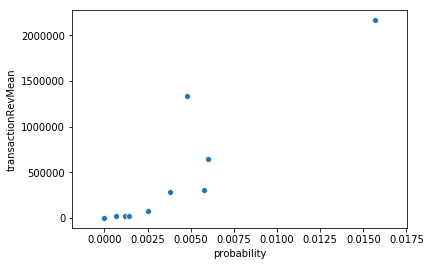

In [46]:
sns.scatterplot(x='probability',y='transactionRevMean', data = browser_transaction_values)

### device browser report
* Clearly this gives a much better seperaton of the data and might be worth considering over frequency encoding
* The issue with this approach is if we exhibit a new feature we may not have a probability value associated with it for is_transaction and so the feature will be NaN.

In [ ]:
### device category 

count_distribution(train,'device.deviceCategory')

In [ ]:
### device OS

# most OS are either Mac 30%, Windows 40% and Android 12% and iOS 10% and Chrome OS 2% everything else can be encoded AS OTHER

count_distribution(train,'device.operatingSystem')

## NaN count

In [ ]:
NaN_value_count(train)

# Analysing the predictor variable

In [ ]:
non_null_transaction_values = train[~train['totals.transactionRevenue'].isnull()]['totals.transactionRevenue']


In [ ]:
sns.distplot(non_null_transaction_values, kde=False, rug = True)

# Test

In [ ]:
g = lambda x : 1 if x>0 else 0 

In [ ]:
g(-100)

In [ ]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

In [ ]:
df_example.head()

In [ ]:
date_time_conversion(df_example, 'date', day=1)

* There are 55 columns in the data set we need to remove ones where the values are all indentical. 

In [ ]:
D = pd.DataFrame(np.arange(10))

In [ ]:
D.iloc[0:3]

In [ ]:
train[~train['totals.transactionRevenue'].isna()].fullVisitorId.unique().shape

In [ ]:
sample  = pd.read_csv("../input/sample_submission.csv")

In [ ]:
sample.head()

In [ ]:
sample.fullVisitorId.unique().shape

In [ ]:
sample.shape

In [ ]:
test.shape

In [ ]:
train.shape

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.countplot(x="device.browser",data=train)

In [ ]:
def count_distribution(dataFrame,column):
    column_count = pd.Series.to_frame(dataFrame.groupby(column).size(),'count')
    column_count.reset_index(inplace = True)
    total = column_count['count'].sum()
    column_count['proportion'] = column_count['count']/total
    return column_count

    

In [ ]:
count_distribution(train,'device.browser')